In [1]:
!pip install SimPEG==0.11.6
!pip install git+https://github.com/simpeg/tle-magnetotelluric_inversion
!pip install pymatsolver==0.1.3

     |████████████████████████████████| 238 kB 5.1 MB/s 
     |████████████████████████████████| 52 kB 708 kB/s 
     |████████████████████████████████| 775 kB 39.0 MB/s 
     |████████████████████████████████| 156 kB 44.3 MB/s 
     |████████████████████████████████| 211 kB 43.7 MB/s 
  Created wheel for SimPEG: filename=SimPEG-0.11.6-py3-none-any.whl size=290020 sha256=416cca9bbf68313a2f1efb32b5cef7a1fa1d96544cfc0ef3ab9b22b1d71e9fcf
  Stored in directory: /root/.cache/pip/wheels/64/80/b5/eb5fb47975a6a342d4364485df93d0399a35b818344f5f74ff
  Created wheel for discretize: filename=discretize-0.7.1-cp37-cp37m-linux_x86_64.whl size=2598084 sha256=94a95fd2994d7c270aec67c61eb60ab69de0cf7bb3a3fc1d19009d5aa61806c5
  Stored in directory: /root/.cache/pip/wheels/d1/02/dc/eb682b15d8e823d672e17726244ff1f40b6808faa85356adba
  Created wheel for geoana: filename=geoana-0.1.2-py3-none-any.whl size=33706 sha256=24b30c0fdfc040720b5f715bc6141716837e72b4a371c7cfed2580152641a861
  Stored in directory: /ro

In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from scipy.constants import mu_0
from SimPEG import (Mesh, Maps, SolverLU, 
                    DataMisfit, Regularization,
                    Optimization, InvProblem, Inversion, 
                    Directives, Utils)
try: 
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as SolverLU

from tleMT.MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
%matplotlib inline

In [3]:
def open_data(loc_file):
    period = []
    rho = []
    phi = []

    with open(loc_file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            period.append(float(row[0]))
            rho.append(float(row[1]))
            phi.append(float(row[2]))

    period = np.array(period)
    rho = np.array(rho)
    phi = np.array(phi)
        
    return period, rho, phi

In [4]:
def plot_res_phase(period, rho, phi, rho_forecast=False, phi_forecast=False, 
                   tp1=False, tp2=False, forecast=False):
    fig, ax = plt.subplots(2, 1, figsize=(15, 5*2))

    if forecast == True:
        ax[0].loglog(period, rho, tp1, lw=2, label = "Data Validasi")
        ax[0].loglog(period, rho_forecast, tp2, lw=2, label = "Data Forecast")
        ax[0].legend(fontsize=10)

        ax[1].semilogx(period, phi, tp1, lw=2, label = "Data Validasi")
        ax[1].semilogx(period, phi_forecast, tp2, lw=2, label = "Data Forecast")
        ax[1].legend(fontsize=10)
    else:
        ax[0].loglog(period, rho, tp1, lw=2)
        ax[1].semilogx(period, phi, tp1, lw=2)
    
    ax[0].set_title('Distribusi Resistivitas Terhadap Periode', fontsize=18)
    ax[0].set_ylabel('$\\rho_a$ $(\\Omega m)$', fontsize=14)
    ax[0].set_ylim(3, rho.max()+800)

    ax[1].set_title('Distribusi Fase Terhadap Periode', fontsize=18)
    ax[1].set_ylabel('$\\phi$ (Hz)', fontsize=14)
    ax[1].set_ylim([0, 90])

    for a in ax:
        a.set_xlabel('Period (s)', fontsize=14)
        a.grid(True, which = 'both', lw=0.5)
        a.set_xlim(period.min(), period.max())
        
    plt.tight_layout()
    plt.show() 

In [5]:
def model_forecast(model, series):
    forecast = []
    for i in range(len(series)-window_size):
        forecast.append(model.predict(series[i:i+window_size][np.newaxis]))
    forecast = np.array(forecast)[:, 0, 0]
    return forecast

In [6]:
def build_mesh(frequency, max_depth_core, ncell_per_skind=1e2, 
               n_skind=2, max_hz_core=5e1):
    rxloc = np.r_[0]
    rx = ZxyRx(rxloc, component='both', frequency=frequency)
    src = MT1DSrc([rx])
    survey = MT1DSurvey([src])
    max_depth_core = max_depth_core
    mesh = survey.setMesh(sigma=1e-2, max_depth_core=max_depth_core,
                          ncell_per_skind=ncell_per_skind, n_skind=n_skind, 
                          core_meshType='log', max_hz_core=max_hz_core)
    return mesh, survey

In [7]:
def model_int(mesh, survey, layers_tops, rho_layers):
    prob = MT1DProblem(mesh, sigmaMap=Maps.ExpMap(mesh), 
                       verbose=True, Solver=Solver)
    prob.pair(survey)
    rho = np.ones(mesh.nC)*np.nan
    for layers_top, rho_layer in zip(layers_tops, 
                                     rho_layers):
        inds = mesh.vectorCCx < layers_top
        rho[inds] = rho_layer

    sigma = 1/rho
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    rho_plt = np.repeat(rho, 2, axis=0)
    return z, rho_plt

In [17]:
def plot_model(period, z, max_depth_core, rho_0, rho_obs, 
               rho_pred, phi_obs, phi_pred, tp, loglog=False):
    period = period[:-window_size]
    rho_obs = rho_obs[:-window_size]
    phi_obs = phi_obs[:-window_size]

    rho_obs_z = np.repeat(rho_obs, round(len(z)/len(rho_obs)))[::-1]
    rho_pred_z = np.repeat(rho_pred, round(len(z)/len(rho_pred)))[::-1]

    if len(z) > len(rho_obs_z):
        z = z[:len(rho_obs_z)]
        rho_0 = rho_0[:len(rho_obs_z)]
    elif len(z) < len(rho_obs_z):
        rho_obs_z = rho_obs_z[:len(z)]
        rho_pred_z = rho_pred_z[:len(z)]
    else:
        z = z
        rho_0 = rho_0
        rho_obs_z = rho_obs_z
        rho_pred_z = rho_pred_z
    
    fig, ax = plt.subplots(3, 1, figsize=(15, 5*3))
    if loglog == True:
        ax[0].loglog(-z, rho_0, '-k', lw=0.8, label='$m_{0}$')
        ax[0].loglog(-z, rho_obs_z, lw=2, label='$d_{true}$')
        ax[0].loglog(-z, rho_pred_z, lw=2, label='$ANN$') 
    else:
        ax[0].semilogy(-z, rho_0, '-k', lw=0.5, label='$m_{0}$')
        ax[0].semilogy(-z, rho_obs_z, lw=2, label='$d_{true}$')
        ax[0].semilogy(-z, rho_pred_z, lw=2, label='$ANN$')

    ax[0].set_xlim(-1*z.max(), max_depth_core)
    ax[0].set_ylim(3, rho_obs_z.max()+800)
    ax[0].set_title('Site 19', fontsize=15)
    ax[0].set_xlabel("Depth (m)", fontsize=13)
    ax[0].set_ylabel("Apparent Resistivity ($\\Omega m$)", fontsize=13)

    ax[1].loglog(period, rho_obs, tp, lw=2, label='$d_{true}$')
    ax[1].loglog(period, rho_pred, lw=2, label='$ANN$')
    ax[1].set_title('Site 19', fontsize=15)  
    ax[1].set_ylabel("Apparent Resistivity ($\\Omega m$)", fontsize=13)
    
    ax[2].semilogx(period, phi_obs, tp, lw=2, label='$d_{true}$')
    ax[2].semilogx(period, phi_pred, lw=2, label='$ANN$')
    ax[2].set_title('Site 19', fontsize=15)
    ax[2].set_ylabel("Phase", fontsize=13)
    ax[2].set_ylim(0, 90)

    for a in ax:
        a.grid(True, which='both', lw=0.4)
        a.legend(fontsize=14)

    for i in range(1, 3):
        ax[i].set_xlim(period.min(), period.max())
        ax[i].set_xlabel('Periode (s)', fontsize=13)

    plt.tight_layout()
    plt.show()

In [9]:
def error(var1, var2):
    mae = 1/len(var1)*np.sum(np.absolute(np.subtract(var2, var1)))
    return mae

# **Memuat Model ANN**

In [10]:
# Menghubungkan ke google drive untuk mengakses data
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
rho_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ANN MT 1D/rho_model.h5')
phi_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ANN MT 1D/phi_model.h5')

print("Ringkasan rho model")
rho_model.summary()
print('\nRingkasan phi model')
phi_model.summary()

Ringkasan rho model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 11,649
Trainable params: 11,649
Non-trainable params: 0
_________________________________________________________________

Ringkasan phi model
Model: "sequential"
_________________________________________________________

# **Inversi Site 10**

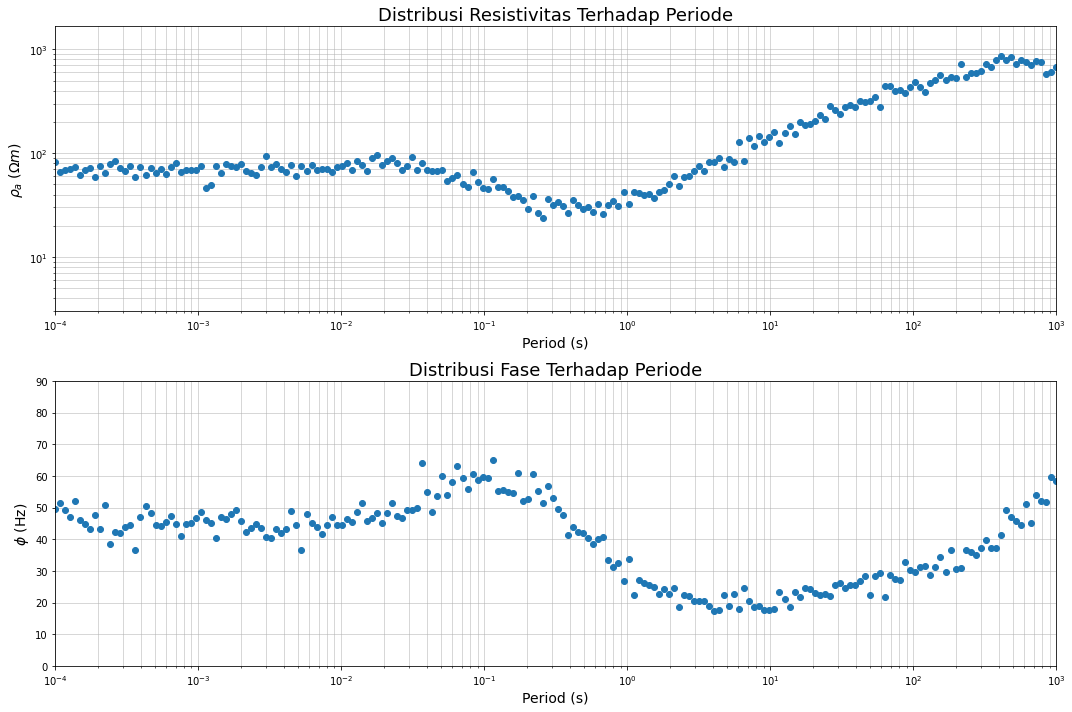

In [12]:
loc_file = '/content/gdrive/MyDrive/ANN MT 1D/Data/data2.csv' # Lokasi data
period, rho, phi = open_data(loc_file)

# Reverse index array
period2 = period[::-1]
rho2 = rho[::-1]
phi2 = phi[::-1]

plot_res_phase(period2, rho2, phi2, tp1='o')

## Forecasting

In [14]:
window_size = 5
batch_size = 100
shuffle_buffer_size = 100

In [15]:
rho_forecast2 = model_forecast(rho_model, rho2)
phi_forecast2 = model_forecast(phi_model, phi2)

rho_error2 = error(rho2[:-window_size], rho_forecast2)
phi_error2 = error(phi2[:-window_size], phi_forecast2)

layers_tops = np.r_[0, -750, -1000, -2500, -3100]
rho_layers = np.r_[70, 8, 60, 250, 850]
frequency = np.logspace(-3, 4, 200)
max_depth_core = 4000
mesh, survey = build_mesh(frequency, max_depth_core)
#plot_mesh(mesh)
z2, rho_02 = model_int(mesh, survey, layers_tops, rho_layers)

>> Smallest cell size = 0 m
>> Padding distance = 316227 m
>> # of padding cells 28
>> # of core cells cells 371


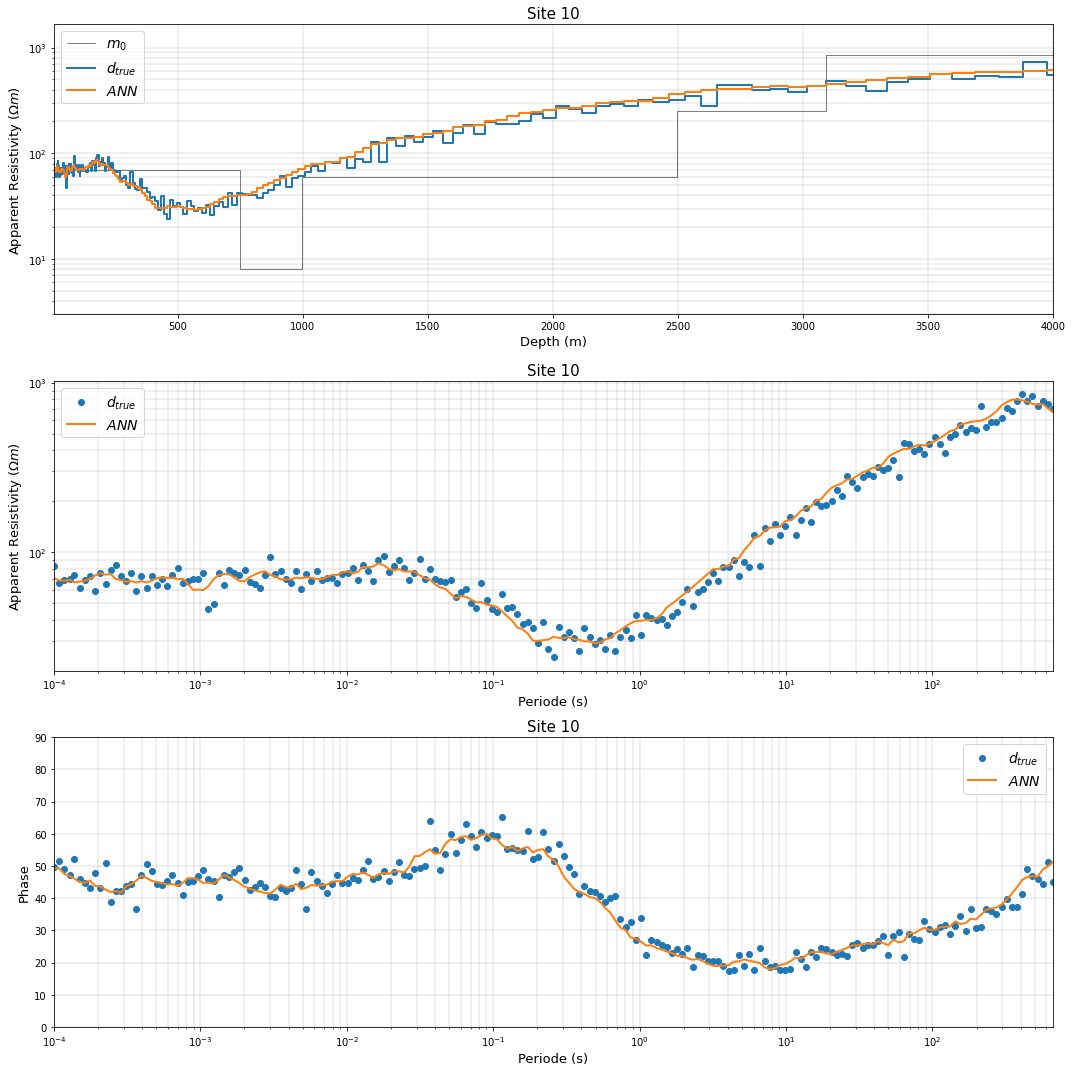


Rho MAE: 15.76 	Phi MAE: 2.15


In [16]:
plot_model(period2, z2, max_depth_core, rho_02, rho2, 
           rho_forecast2, phi2, phi_forecast2, 'o', loglog=False)

print('\nRho MAE: {:0.2f} \tPhi MAE: {:0.2f}'.format(rho_error2, phi_error2))

# **Inversi Site 19**

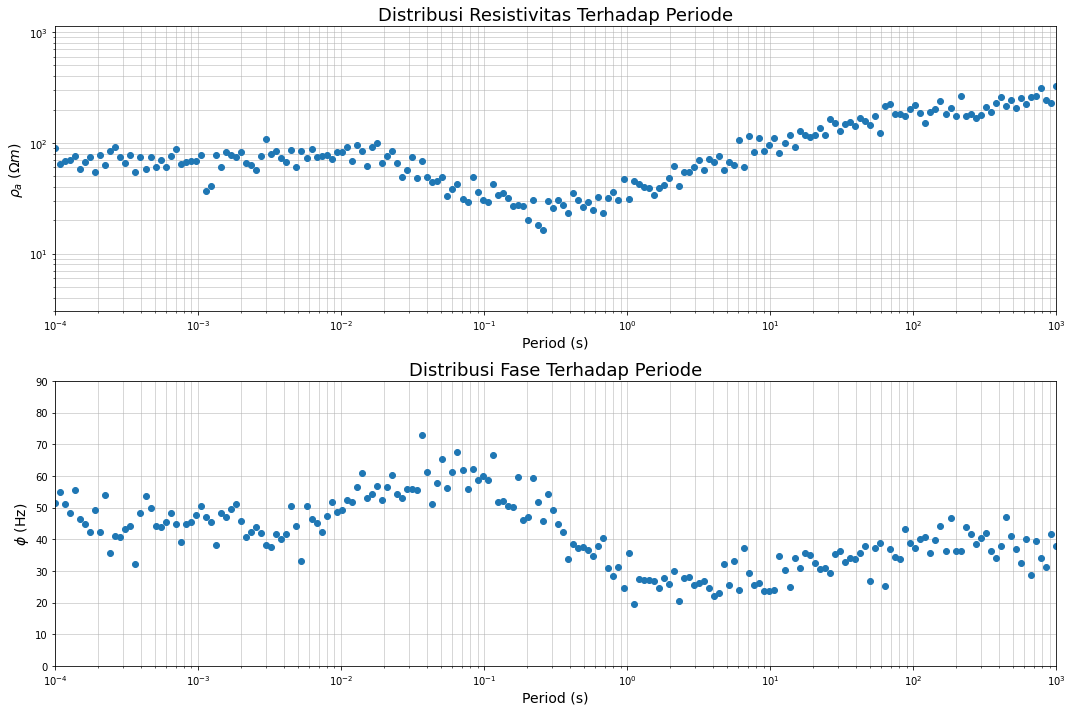

In [18]:
loc_file = '/content/gdrive/MyDrive/ANN MT 1D/Data/data3.csv' # Lokasi data
period, rho, phi = open_data(loc_file)

# Reverse index array
# Reverse index array
period3 = period[::-1]
rho3 = rho[::-1]
phi3 = phi[::-1]

plot_res_phase(period3, rho3, phi3, tp1='o')

## Forecasting

In [19]:
rho_forecast3 = model_forecast(rho_model, rho3)
phi_forecast3 = model_forecast(phi_model, phi3)

rho_error3 = error(rho3[:-window_size], rho_forecast3)
phi_error3 = error(phi3[:-window_size], phi_forecast3)

layers_tops = np.r_[0, -500, -750, -2250]
rho_layers = np.r_[70, 8, 60, 250]
frequency = np.logspace(-3, 4, 200)
max_depth_core = 4000
mesh, survey = build_mesh(frequency, max_depth_core)
#plot_mesh(mesh)
z3, rho_03 = model_int(mesh, survey, layers_tops, rho_layers)

>> Smallest cell size = 0 m
>> Padding distance = 316227 m
>> # of padding cells 28
>> # of core cells cells 371


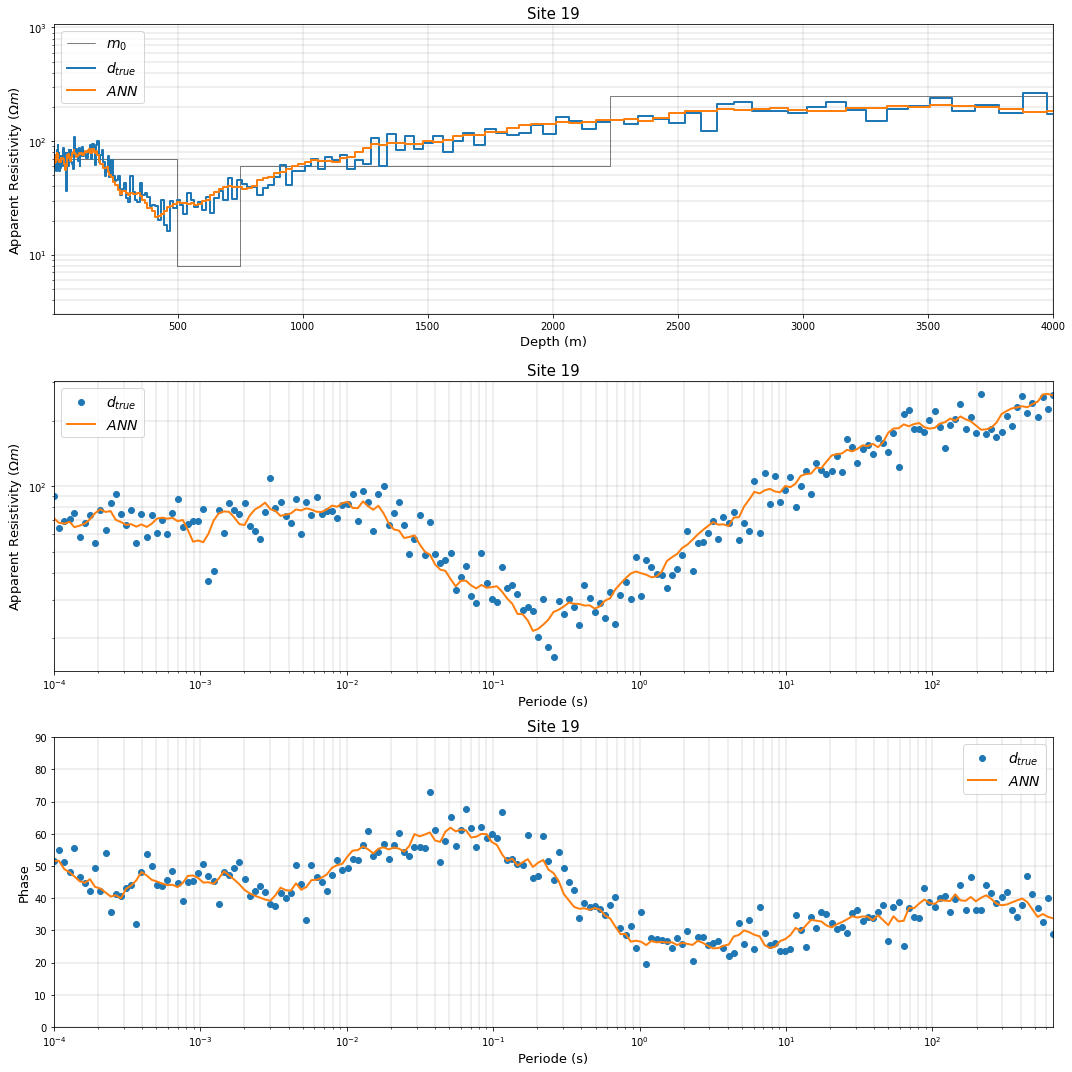


Rho MAE: 11.04 	Phi MAE: 3.12


In [20]:
plot_model(period3, z3, max_depth_core, rho_03, rho3, 
           rho_forecast3, phi3, phi_forecast3, 'o', loglog=False)

print('\nRho MAE: {:0.2f} \tPhi MAE: {:0.2f}'.format(rho_error3, phi_error3))